![example](images/director_shot.jpeg)

# Project Title

**Authors:** Student 1, Student 2, Student 3
***

## Overview

A one-paragraph overview of the project, including the business problem, data, methods, results and recommendations.

## Business Problem

Summary of the business problem you are trying to solve, and the data questions that you plan to answer to solve them.

***
Questions to consider:
* What are the business's pain points related to this project?
* How did you pick the data analysis question(s) that you did?
* Why are these questions important from a business perspective?
***

## Data Understanding

Describe the data being used for this project.
***
Questions to consider:
* Where did the data come from, and how do they relate to the data analysis questions?
* What do the data represent? Who is in the sample and what variables are included?
* What is the target variable?
* What are the properties of the variables you intend to use?
***

In [8]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

%matplotlib inline

In [3]:
# Here you run your code to explore the data
imdb_akas_df = pd.read_csv('../data/zippedData/imdb.title.akas.csv.gz')
imdb_ratings_df = pd.read_csv('../data/zippedData/imdb.title.ratings.csv.gz')
imdb_principals_df = pd.read_csv('../data/zippedData/imdb.title.principals.csv.gz')
imdb_name_df = pd.read_csv('../data/zippedData/imdb.name.basics.csv.gz')
movie_gross_df = pd.read_csv('../data/zippedData/bom.movie_gross.csv.gz')

## Data Preparation

Describe and justify the process for preparing the data for analysis.

***
Questions to consider:
* Were there variables you dropped or created?
* How did you address missing values or outliers?
* Why are these choices appropriate given the data and the business problem?
***

<br>

Finding the top 20 directos by worldwide gross:
- Begin with a main DatFrame of all movie titles from the US region and drop the extra rows for movies listed more than once.
- Then add the ratings for each movie by joining with the Imdb ratings csv and reduce columns to only the movies unique id, name and average rating.  


Add Directors, their name and the "worldwide gross" for each movie:
- Build another DataFrame from the IMDb priciples csv containing only those in the director category, then attach to main DataFrame using each movies unique id. 
- Then use each directors unique id to add on their name contained in the IMDb name csv.
- Add each movies domestic and foreign gross contaied in the movie gross csv from Box Office Mojo by IMDb Pro and create a worldwide gross column by adding those two columns.

Orgonizing DateFrame by director:
- Drop rows that do not have either a name for the movie director or a value for worldwide gross
- Grouping the movies by director and reducing columns to the average worldwide gross and the average rating

In [5]:
# Here you run your code to clean the data
# finding top 20 directors
titles = imdb_akas_df[imdb_akas_df['region'] == 'US'].drop_duplicates(subset=['title_id'])
add_ratings = titles.join(imdb_ratings_df.set_index('tconst'), on='title_id')
add_ratings = add_ratings[['title_id', 'title', 'averagerating',]]

# add directors names and make worldwid gross column
directors = imdb_principals_df[imdb_principals_df['category'] == 'director']
add_director = add_ratings.join(directors.set_index('tconst'), on='title_id')
add_dir_name = add_director.join(imdb_name_df.set_index('nconst'), on='nconst')
add_gross = add_dir_name.join(movie_gross_df.set_index('title'), on='title')

add_gross['foreign_gross'] = add_gross['foreign_gross'].str.replace(',', '').apply(lambda x: float(x))
add_gross['worldwide_gross'] = add_gross['domestic_gross'] + add_gross['foreign_gross']

# group by director
dropped = add_gross.dropna(subset=['primary_name','worldwide_gross'])
director_df = dropped.groupby('primary_name').mean()
director_df = director_df[['averagerating', 'worldwide_gross']]

## Data Modeling
Describe and justify the process for analyzing or modeling the data.

***
Questions to consider:
* How did you analyze or model the data?
* How did you iterate on your initial approach to make it better?
* Why are these choices appropriate given the data and the business problem?
***

Find top 20 directors:
- Sort the directors by worldwide gross and limit to the top 20 
- Sort another version of this top 20 DataFrame by rating for graphing later on

Clean for graphing:
- Create a list of each directors name with their average rating
- Store each movies worldwide gross in a seperate variable

Find best directors in the top 20:
- Create top 10 lists for each of the average worldwide gross and average rating columns
- Use intersection method to find the directors that appear in both new top 10 lists

Find the correlation between a directors' average worldwide gross and the average rating of their movies

In [10]:
# Here you run your code to model the data
# Find th etop 20 directors
top20_directors = director_df.sort_values(by='worldwide_gross', ascending=False )[:20]
top20_dir_by_rating = top20_directors.sort_values(by='averagerating')

# clean for graphinig
names = top20_dir_by_rating.index
ratings = top20_dir_by_rating.averagerating.values.round(2)
names_with_rating = [x+': '+str(y) for x,y in zip(names, ratings)]
gross = top20_dir_by_rating.worldwide_gross

# find best directors
top_rated = top20_dir_by_rating[-10:].averagerating.index
top_grossed = top20_directors.worldwide_gross[:10].index
top_directors = top_rated.intersection(top_grossed)

# correlation
corr = round(top20_directors.corr().iloc[0][1], 2)
print()
print(f'Correlation between average worldwide gross and average rating for the top 20 directors is: {corr}')


Correlation between average worldwide gross and average rating for the top 20 directors is: 0.07


Graphing the top 20 directors for worlwide gross, ordered on the Y-axis by average rating. Directors who are top 10 in both categories are labeled in green

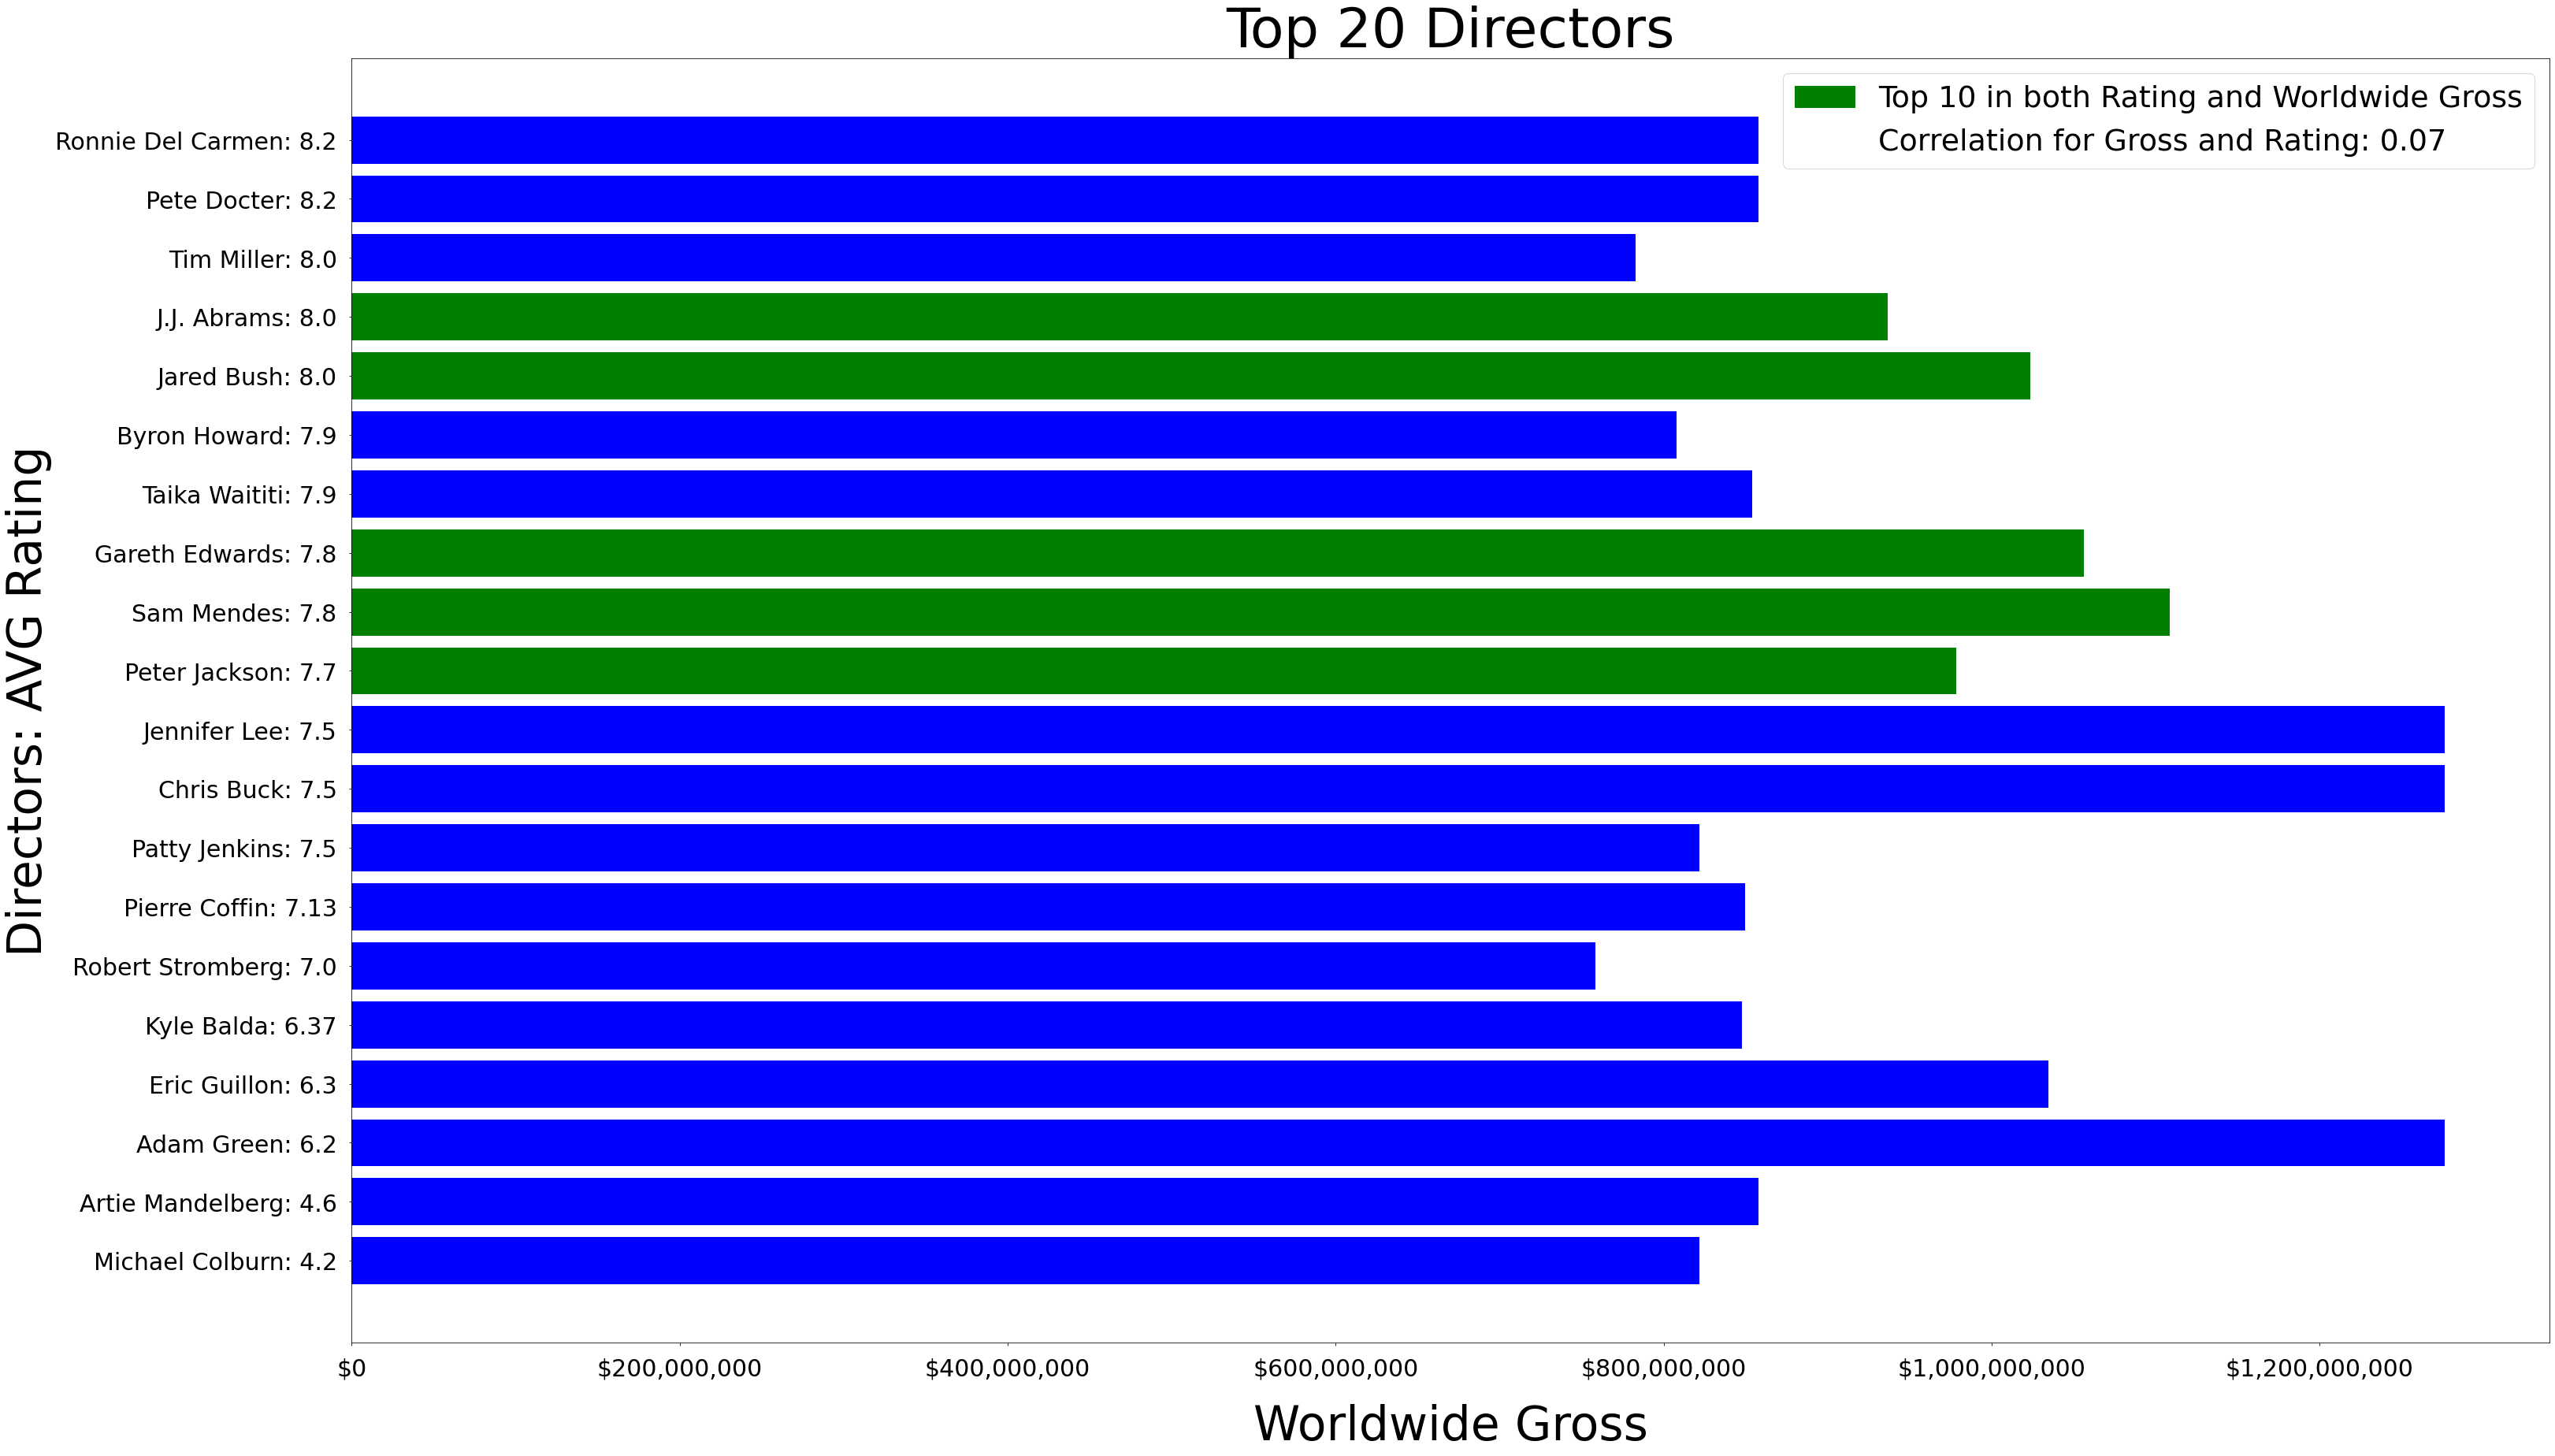

In [9]:
fig, ax = plt.subplots(figsize=(50,30))

# create list of bar color codes
bin_colors = ['b' if x not in top_directors else 'g' for x in top20_dir_by_rating.index]

# Bar chart
ax.barh(names_with_rating, gross, color=bin_colors)
ax.set_title('Top 20 Directors', size=70)

# Y-axis
ax.set_ylabel('Directors: AVG Rating', size=60)
ax.set_yticks(list(range(0,20)))
ax.set_yticklabels(names_with_rating, size=30)

# X-axis
ax.set_xlabel('Worldwide Gross', size=60)
ax.xaxis.labelpad = 30
x_ticks = [0,200000000, 400000000, 600000000, 800000000, 1000000000, 1200000000]
x_lables = ['$0', '$200,000,000', '$400,000,000', '$600,000,000', \
            '$800,000,000', '$1,000,000,000', '$1,200,000,000']
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_lables, size=30)
ax.tick_params(axis='both', which='major', pad=15)

# Legend
green_patch = mpatches.Patch(color='green', label='Top 10 in both Rating and Worldwide Gross')
corr_patch = mpatches.Patch(color='None',label=f'Correlation for Gross and Rating: {corr}')
plt.legend(handles=[green_patch, corr_patch], prop={'size': 38}, loc='upper right');
plt.savefig('top_directors.png')

## Evaluation
Evaluate how well your work solves the stated business problem.

***
Questions to consider:
* How do you interpret the results?
* How confident are you that your results would generalize beyond the data you have?
* How confident are you that this model would benefit the business if put into use?
***

There is no correlation between a directors' average worldwide gross and average movie rating. This is true for both the top 20 directors and the entire dataset of directors. This gives us confidence that the results will generalize beyond the data in this analysis. 

## Conclusions
Provide your conclusions about the work you've done, including any limitations or next steps.

***
Questions to consider:
* What would you recommend the business do as a result of this work?
* What are some reasons why your analysis might not fully solve the business problem?
* What else could you do in the future to improve this project?
***

When making the decision of selecting a director, it will be important for the studio to set a focused intentsion for whether the movie is to be hugly succesfull at the box office or of a quality that raises the reception of the studio.